# Feature engineering, importance and selection

- Embedded methods
- Permutation importance
- Recursive feature elimination
- Filtering methods

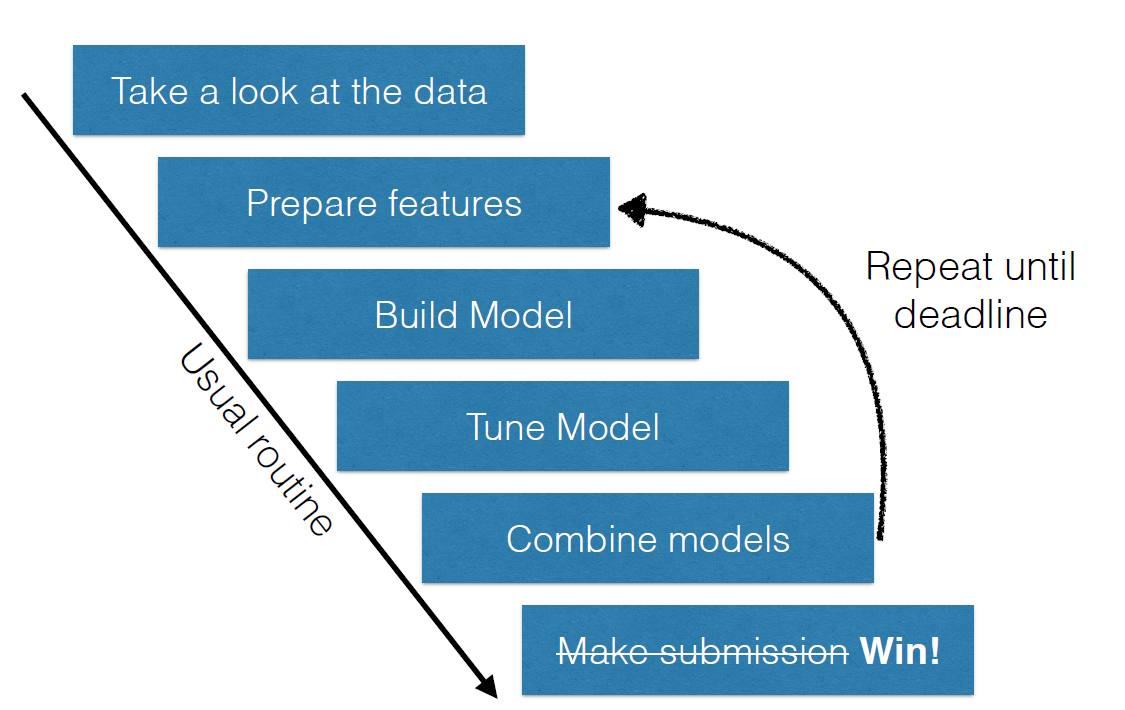

In [1]:
import pandas as pd
import numpy as np
import numpy.testing as np_testing
import matplotlib.pyplot as plt

%matplotlib inline

### Data preparation

UCI MAGIC dataset: https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope

In [2]:
data = pd.read_csv("magic_data.csv")
col_names = data.drop('Label', axis=1).columns

print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [3]:
X = data[col_names].values

y = data['Label'].values

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11, stratify=y)

# Embedded methods

## Gradient Boosting based feature importances

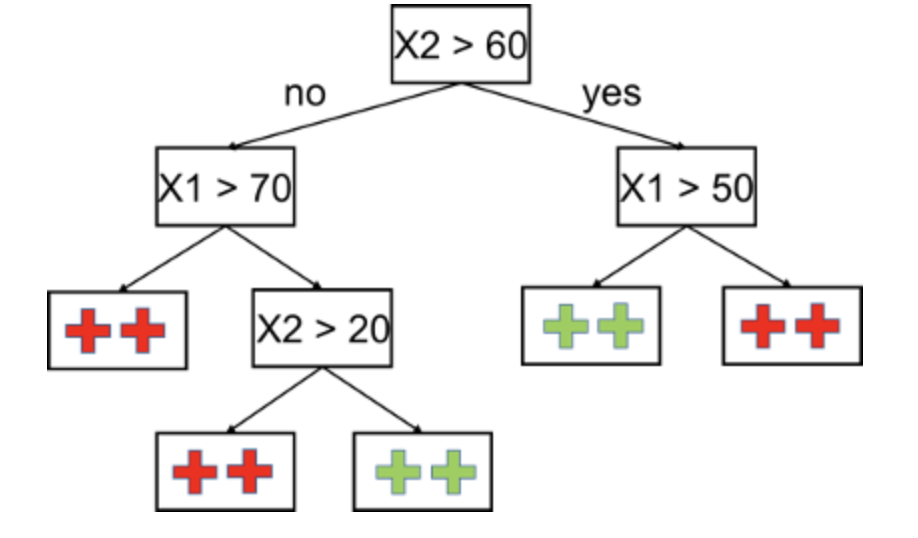

Let $T(f)$ be the set of all nodes which use feature $f$ to make split. Then, feature importance $Imp(f)$ of $f$:

$$
Imp(f) = \sum_{t \in T(f)} n_t \Delta I(t)
$$

$$
\Delta I(t) = I(t) - \sum_{c \in children} \frac{n_c}{n_t} I(c)
$$

where
- $n_{t}$ - number of objects in node $t$;
- $I(t)$ – impurity function (gini, cross-entropy, MSE) value for the node.

Feature importances estimated by each tree in an ensemble are averaged over all trees in this ensemble.

In [8]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgbm

In [6]:
def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
    plt.show()

In [7]:
# gb = lgbm.LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=11, importance_type='gain', n_jobs=10)
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=11)
gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50, random_state=11)

In [8]:
y_test_proba = gb.predict_proba(X_test)[:, 1]

roc_auc_gb = metrics.roc_auc_score(y_test, y_test_proba)
print("Test ROC AUC: ", roc_auc_gb)

Test ROC AUC:  0.9150013987028729


In [9]:
f_imps_gb = gb.feature_importances_

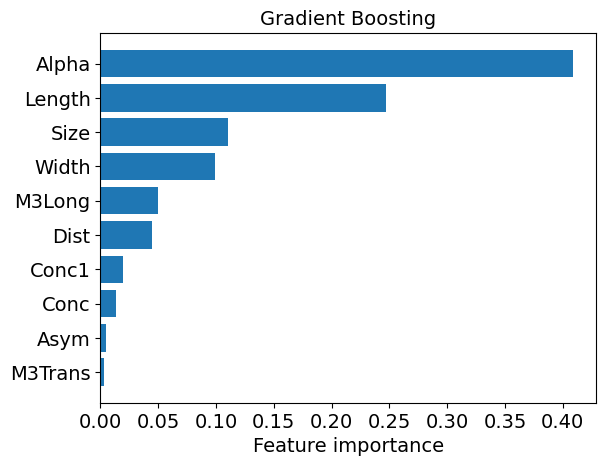

In [10]:
plot_feature_importances(f_imps_gb, np.array(col_names), "Gradient Boosting")

## Linear model based feature importances

Consider a linear model with regularization ($L_1$ or $L_2$ penalty):

$$
\hat{y}=w_0 + w_1 f_1+ w_2 f_2 + ... + w_k f_k
$$

If features are normalized (have the same ranges), feature importance $Imp(f_i)$ of $f_i$ is equal to:

$$
Imp(f_i) = | w_i |
$$


#### Task: Estimate feature importacnes using linear model as it is described above.

**Hints:** use `StandardScaler()` to normalize feature values. Also, use `LogisticRegression(solver='liblinear', penalty='l2', C=C, random_state=11)` for the linear model. To get values of the model coefficients use `<model>.coef_[0]` method.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def get_feature_imp_with_lin_mod(X_train, y_train, C=1.0):
    """
    Estimate feature importances using linear model with regularization.

    Parameters:
    -----------
    X_train: numpy.ndarray
        Object features matrix.
    y_train: numpy.array
        Vector of true class labels.
    C: float
        Inverse of regularization strength; must be a positive float.
    
    Returns:
    --------
    f_imps_lin: numpy.array
        Estimated feature importances.
    """

    raise NotImplementedError
    
    return f_imps_lin

In [11]:
f_imps_lin = get_feature_imp_with_lin_mod(X_train, y_train, C=1.)

Expected output:

<center>   
    
```python
array([1.23276898, 0.08849417, 0.31007411, 0.07866152, 0.69042639,
       0.01030818, 0.31858178, 0.01445776, 1.20855327, 0.0711564 ])
    
``` 
    
</center>

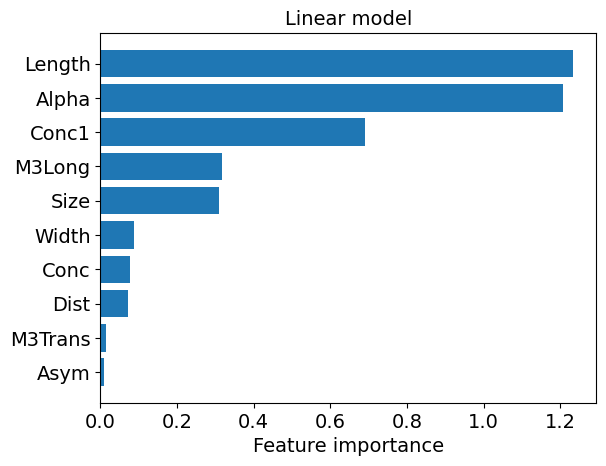

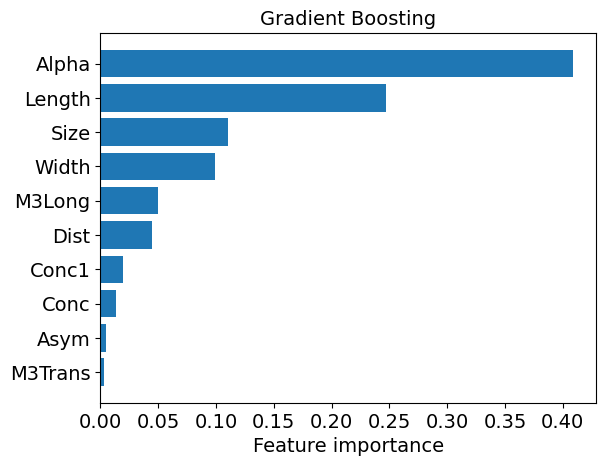

In [13]:
plot_feature_importances(f_imps_lin, np.array(col_names), "Linear model")
plot_feature_importances(f_imps_gb, np.array(col_names), "Gradient Boosting")

Do you have any ideas why the feature importances are so different for these two models? Let's compare quality of the models.

In [14]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

clf = LogisticRegression(solver='liblinear', penalty='l2', C=1.0, random_state=11)
clf.fit(X_train_ss, y_train)

y_test_proba = clf.predict_proba(X_test_ss)[:, 1]

roc_auc_lin = metrics.roc_auc_score(y_test, y_test_proba)

print("Test ROC AUC (GB)    : ", roc_auc_gb)
print("Test ROC AUC (LogReg): ", roc_auc_lin)

Test ROC AUC (GB)    :  0.9150013987028729
Test ROC AUC (LogReg):  0.8367647789157084


# Permutation importance


Algorithm:
- Train your model
- Calculate quality measure $Q_0$ on the test set
- For a feature $f$:
  - Replace given values with random values from the same distribution (perform random shuffling)
  - Calculate quality measure $Q_f$ on the test set
  - Estimate feature importance: $Imp(f)=Q_0 - Q_f$

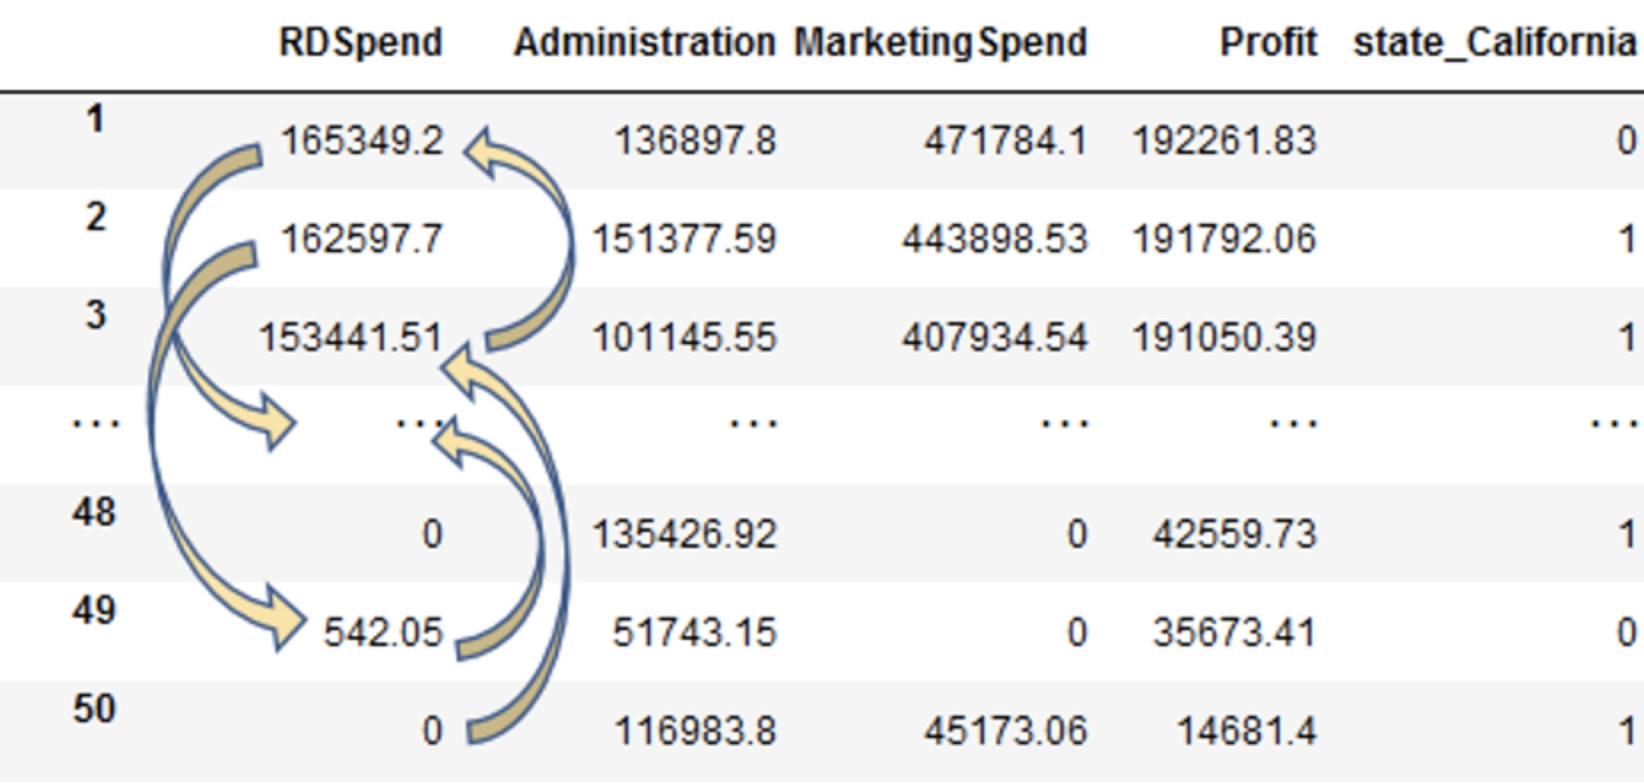

#### Task: Estimate feature importances using algorithm described above. 

**Hint:** to shuffle values of one feature use `numpy.random.RandomState(42).shuffle()`

In [47]:
def get_permutation_importance(X_test, y_test, model):
    """
    Estimate feature importances using linear model with regularization.

    Parameters:
    -----------
    X_test: numpy.ndarray
        Object features matrix.
    y_test: numpy.array
        Vector of true class labels.
    model: object
        A classifier fitted on the train sample.
    
    Returns:
    --------
    f_imps_gen: numpy.array
        Estimated feature importances.
    """
    
    # define a list for the feature importances
    permut_imps = []

    # calculate the base quality value according to the algorithm
    y_test_proba = model.predict_proba(X_test)[:, 1]
    q_0 = ...

    # for each feature in the sample estimate its importance
    for i in range(X_test.shape[1]):
        
        # do not forget to make a copy of X_test!
        X_test_copy = ...
        
        # shuffle values of the i-th feature
        ...
        
        # calculate quality metric value
        X_test_copy = np.nan_to_num(X_test_copy)
        y_test_proba = model.predict_proba(X_test_copy)[:, 1]
        q_f = ...
        
        # estimate importance of the feature
        imp = ...
        permut_imps.append(imp)
        
    return np.array(permut_imps)

In [48]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=11)

In [12]:
permut_imps = get_permutation_importance(X_test, y_test, model)

Expected output if you're using sklearn GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11):

<center>   
    
```python
array([0.04637988, 0.05260054, 0.08529961, 0.01983549, 0.00770327,
       0.00362227, 0.00992063, 0.00324071, 0.19450321, 0.01429451])
    
``` 
    
</center>

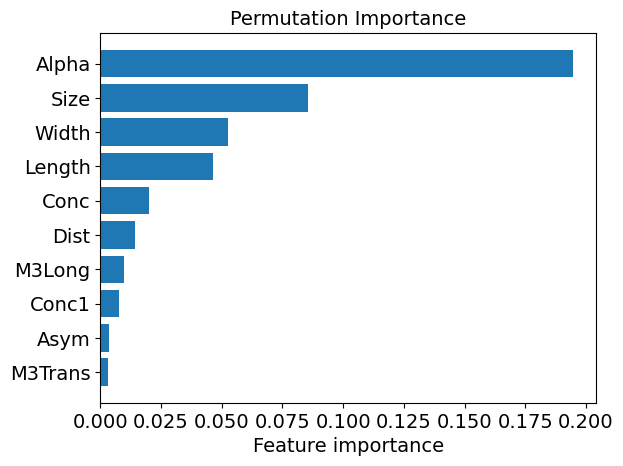

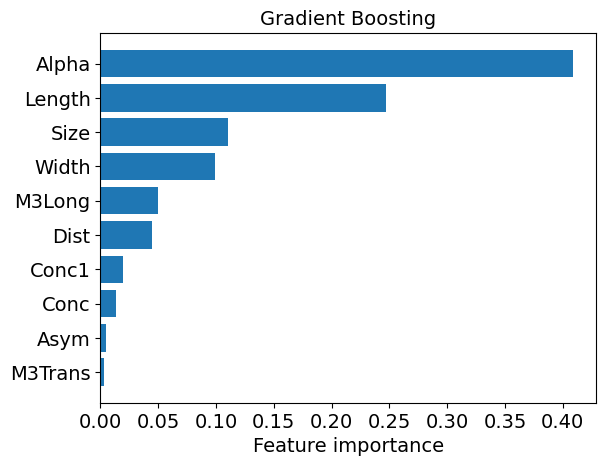

In [50]:
plot_feature_importances(permut_imps, np.array(col_names), "Permutation Importance")
plot_feature_importances(f_imps_gb, np.array(col_names), "Gradient Boosting")

# Recursive feature elimination

- Train a model on the full set of features
- Estimate feature importance (based on the model)
- Remove the least important feature
- Repeat

One of the most popular libraries with this functionality -- MLXtend.

#### Task: Implement recursive feature elimination.

**Hint:** use `model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=11)`.

In [53]:
def recursive_feature_elimination(X_train, X_test, y_train, y_test, col_names):
    """
    Estimate feature importances with different subsets of features eliminating one feature for iteration.

    Parameters:
    -----------
    X_train: numpy.ndarray
        Object features matrix for training model.
    y_train: numpy.array
        Vector of true class labels for training model.
    X_test: numpy.ndarray
        Object features matrix for testing features subset.
    y_test: numpy.array
        Vector of true class labels for testing features subset.
    col_names: list or numpy.array
        Features names.
    
    Returns:
    --------
    roc_auc_scores: list
        Estimated quality of every features subset in recursive feature elimination.
    """

    # make copies for further steps
    X_train_curr = X_train.copy()
    X_test_curr  = X_test.copy()
    col_names_curr = col_names.copy()

    # for storing roc auc scores
    roc_auc_scores = []

    # eliminate feature by feature
    for i in range(X.shape[1]):

        print("Features: ", col_names_curr)

        # 1. fit the model using current set of features
        model = ...
        model.fit(X_train_curr, y_train)
        
        # 2. get feature importances
        f_imps = ...

        # 3. compute roc auc of the model
        y_test_proba = model.predict_proba(X_test_curr)[:, 1]
        auc = ...

        auc = np.round(auc, 4)
        print("ROC AUC: ", auc)
        roc_auc_scores.append(auc)

        # 4. remove feature with the least importance
        mask = ...
        X_train_curr = X_train_curr[:, mask]
        X_test_curr  = X_test_curr[:, mask]
        col_names_curr = col_names_curr[mask]

        print("\n")

    return roc_auc_scores

In [9]:
col_names

Index(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans',
       'Alpha', 'Dist'],
      dtype='object')

In [54]:
roc_auc_scores = recursive_feature_elimination(X_train, X_test, y_train, y_test, col_names)

Features:  Index(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans',
       'Alpha', 'Dist'],
      dtype='object')
ROC AUC:  0.9235


Features:  Index(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'Alpha',
       'Dist'],
      dtype='object')
ROC AUC:  0.9232


Features:  Index(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'M3Long', 'Alpha', 'Dist'], dtype='object')
ROC AUC:  0.9229


Features:  Index(['Length', 'Width', 'Size', 'Conc1', 'M3Long', 'Alpha', 'Dist'], dtype='object')
ROC AUC:  0.9218


Features:  Index(['Length', 'Width', 'Size', 'M3Long', 'Alpha', 'Dist'], dtype='object')
ROC AUC:  0.9187


Features:  Index(['Length', 'Width', 'Size', 'M3Long', 'Alpha'], dtype='object')
ROC AUC:  0.9153


Features:  Index(['Length', 'Width', 'Size', 'Alpha'], dtype='object')
ROC AUC:  0.9113


Features:  Index(['Length', 'Width', 'Alpha'], dtype='object')
ROC AUC:  0.8862


Features:  Index(['Length', 'Alpha'], dtype='object')
ROC AUC:  0.8666


Fe

In [13]:
print(roc_auc_scores)

Expected output:

<center>   
    
```python
[0.9235, 0.9232, 0.9229, 0.9218, 0.9187, 0.9153, 0.9113, 0.8862, 0.8666, 0.7823]
    
``` 
    
</center>

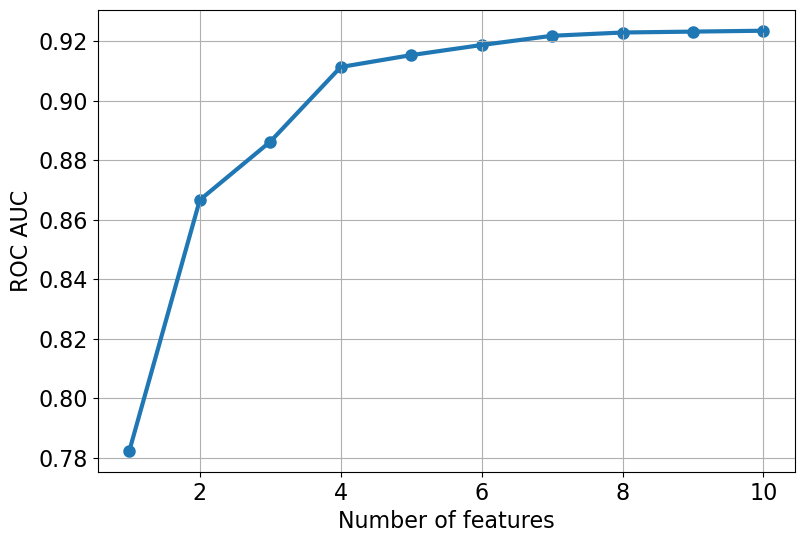

In [58]:
nf = np.arange(1, len(roc_auc_scores)+1)[::-1]
plt.figure(figsize=(9, 6))

plt.plot(nf, roc_auc_scores, linewidth=3)
plt.scatter(nf, roc_auc_scores, linewidth=3)

plt.xlabel("Number of features", size=16)
plt.ylabel("ROC AUC", size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid()
plt.show()

# Filtering methods

Let's select features by counting some function for each feature. Based on the values of this function, we will choose the most important features.

We will consider t-statistics as such a function:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

$\mu$, $\sigma$, $n$, are mean, standard deviation and number of objects of each class respectively.

#### Task: Leave top 5 features with the highest value of $t$ and measure the quality.

In [59]:
def calculate_t_stats(X_train, col_names):
    """
    Estimate feature importances for every feature in X_train.

    Parameters:
    -----------
    X_train: numpy.ndarray
        Object features matrix for training model.
    col_names: list or numpy.array
        Features names.
    
    Returns:
    --------
    features_t_stats: dict
        Dictionary containing feature name and its t-statistic.
    """
    
    raise NotImplementedError
    
    return features_t_stats